# Data Preprocessing

In [1]:
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
from datetime import datetime

In [2]:
# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'
input_window = 9
output_window = 1   # min 1
train = False

sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= input_window + output_window: 
                values_temp = data['Loss'].values
                if max(values_temp) < 2 and min(values_temp) > 0:  # make sure data makes sense
                    sequences.append(values_temp)
        except:
            print(filename)

# crop to 60 values max
input_length = 60
sequences = [s if len(s) <= input_length else s[:input_length]for s in sequences]
flattened = list(itertools.chain(*sequences))
MEAN_GLOBAL, STD_GLOBAL = np.mean(flattened), np.std(flattened)
print("number of sequences:", len(sequences), "MEAN_GLOBAL:", MEAN_GLOBAL, "STD_GLOBAL:", STD_GLOBAL)

number of sequences: 332 MEAN_GLOBAL: 0.6728278730772329 STD_GLOBAL: 0.40318570563162165


### Data visualization

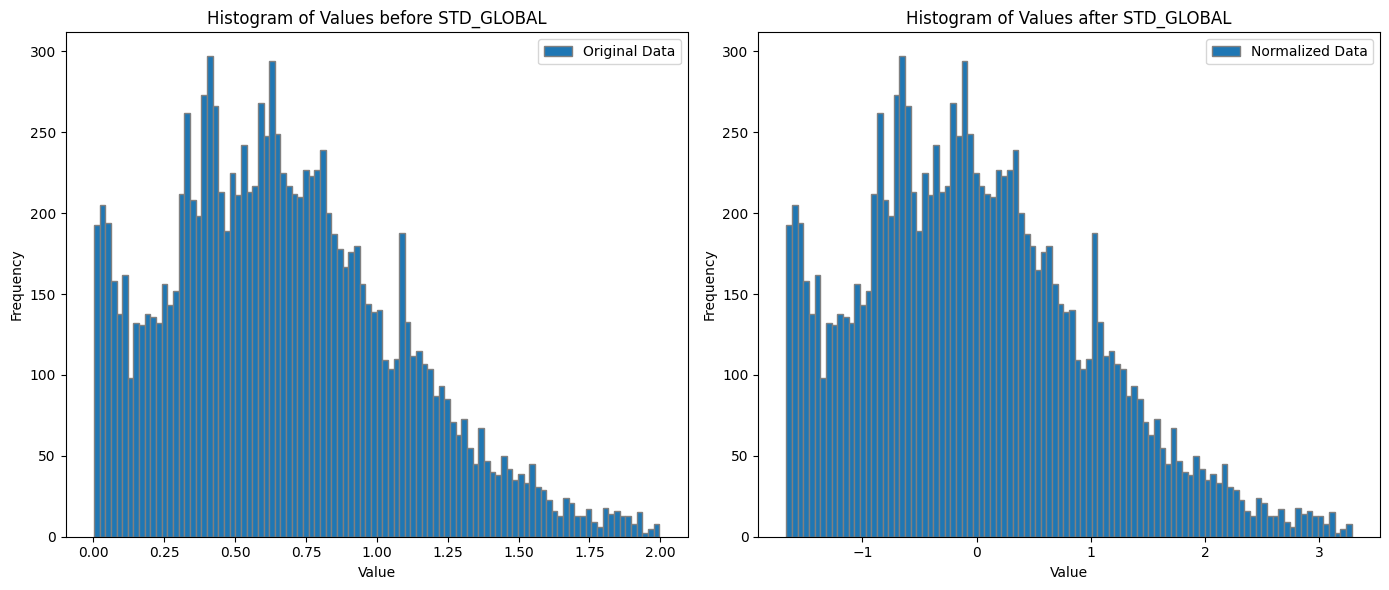

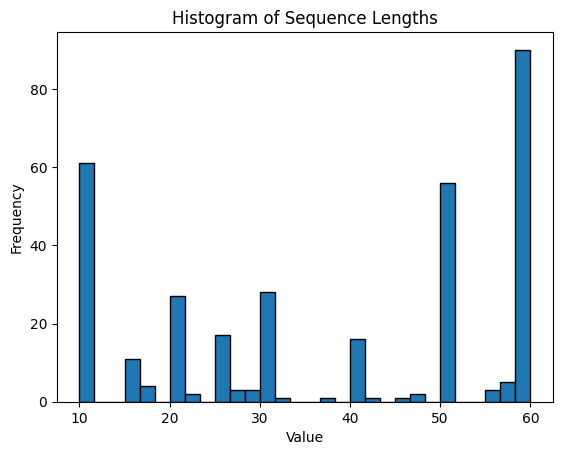

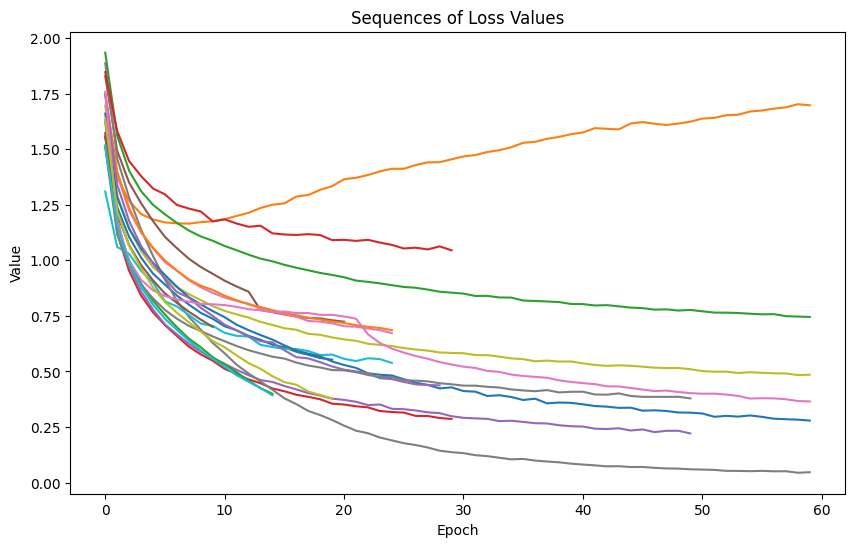

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(flattened, bins=100, edgecolor="grey", label='Original Data')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Values before STD_GLOBAL')

ax[1].hist([(s-MEAN_GLOBAL)/STD_GLOBAL for s in flattened], bins=100, edgecolor="grey", label='Normalized Data')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Values after STD_GLOBAL')

ax[0].legend()
ax[1].legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

plt.hist([len(s) for s in sequences], bins=input_length//2, edgecolor='black')  
#plt.hist(flattened, bins=500, edgecolor='black')  
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.show()

plt.figure(figsize=(10, 6))
for seq in random.sample(sequences, k=20):
    plt.plot(seq)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Sequences of Loss Values')
plt.show()

## Data preparation

In [4]:
train_split = 0.8
train_split_index = int(len(sequences) * train_split)
sequences_standardized = [(s-MEAN_GLOBAL)/STD_GLOBAL for s in sequences]
flattened_s = list(itertools.chain(*sequences_standardized))
print("new mean and std of standardized sequences:", np.mean(flattened_s), np.std(flattened_s))

train_sequences_not_augmented, test_sequences = sequences_standardized[:train_split_index], sequences_standardized[train_split_index:]
train_sequences = []
for seq in train_sequences_not_augmented:
    for ix in range(2, len(seq)+1):
        train_sequences.append(seq[:ix])
        
print("train samples:", len(train_sequences), "test samples (not augmented that's why fewer):", len(test_sequences))

new mean and std of standardized sequences: -2.0142630505561349e-16 1.0
train samples: 9889 test samples (not augmented that's why fewer): 67


In [5]:
class FloatSequenceDataset(Dataset):
    def __init__(self, sequences):
        """
        Args:
            sequences (list of lists): A list of sequences, where each sequence is a list of floats.
        """
        self.data = sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        inputs = torch.tensor(sequence[:-1], dtype=torch.float32).unsqueeze(-1)  # All but the last value
        target = torch.tensor(sequence[-1], dtype=torch.float32)  # Last value is the target
        return inputs, target

# Collate function to handle variable-length sequences
def collate_variable_length(batch):
    inputs, targets = zip(*batch)
    lengths = [seq.size(0) for seq in inputs]

    # Pad inputs
    padded_inputs = torch.zeros(len(inputs), input_length, 1)
    for i, seq in enumerate(inputs):
        padded_inputs[i, :seq.size(0)] = seq

    # Generate 2D key padding mask (batch_size, input_length)
    key_padding_mask = torch.full((len(inputs), input_length), True, dtype=torch.bool)  # Start with all True (padded positions)
    for i, length in enumerate(lengths):
        key_padding_mask[i, :length] = False

    targets = torch.stack(targets)
    return padded_inputs, targets, key_padding_mask


# Model Architecture

### Negative Log-Likelihood (NLL) Loss for a Gaussian Distribution

The **negative log-likelihood (NLL)** loss is given by:

$$
\text{NLL Loss} = \frac{1}{2} \left[ \log(\sigma^2) + \frac{(y - \mu)^2}{\sigma^2} \right]
$$

Where:
- $y$: Ground-truth target.
- $\mu$: Predicted mean.
- $\sigma^2 $: Predicted variance.

#### Components of the Loss:
1. $ \log(\sigma^2)$: Penalizes large variances, encouraging the model to make confident predictions.
2. $\frac{(y - \mu)^2}{\sigma^2}$: Measures the squared error normalized by variance, penalizing large deviations when variance is small.


In [6]:
###################################################
# custom loss functions that penalizes negative values (after de-standardizing)
###################################################

def custom_loss(predictions, targets):
    # Standard loss
    base_loss = base_loss_fn(predictions, targets)

    # De-standardize predictions
    de_standardized_preds = (predictions * STD_GLOBAL) + MEAN_GLOBAL

    # Add penalty for negative de-standardized predictions
    penalty = torch.mean(torch.relu(-de_standardized_preds))  # Relu ensures penalty is only for negatives

    return base_loss + (base_loss/(10*len(predictions))) * penalty  # make sure not big magnitud of 


def custom_loss_nll(predictions, targets):
    mean, log_var = predictions  # Predictions now include mean and log variance
    var = torch.exp(log_var)  # Ensure variance is positive

    # Negative log-likelihood loss
    nll_loss = 0.5 * (torch.log(var) + ((targets - mean) ** 2) / var)
    nll_loss = torch.mean(nll_loss)

    # Regularization term for variance
    variance_reg = torch.mean(var)  # Penalize large variance values
    variance_reg_weight = 0.1  # Small weight for regularization term

    # Final loss includes variance regularization
    return nll_loss + variance_reg_weight * variance_reg




###################################################
# Custom Transformer Class
###################################################
class FloatSequenceTransformer(nn.Module):
    def __init__(self, embedding_dim=32, num_heads=1, num_layers=1, dropout=0.2):
        super(FloatSequenceTransformer, self).__init__()
        
        self.embedding = nn.Linear(1, embedding_dim)
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.num_heads = num_heads
        self.num_layers = num_layers
        

        transformer_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, 
                                                       batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(embedding_dim, 1)  # NO UNCERTAINTY
        #self.output_layer = nn.Linear(embedding_dim, 2)

    def generate_positional_encoding(self, seq_length, device):
        position = torch.arange(seq_length, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2, device=device).float() * -(np.log(10000.0) / self.embedding_dim))
        pe = torch.zeros(seq_length, self.embedding_dim, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe
    
    def forward(self, x, key_padding_mask):
        seq_length = x.size(1)
        x = self.embedding(x)
        positional_encoding = self.generate_positional_encoding(seq_length, x.device)
        x = x + 0.1 * positional_encoding # maybe positional encoding too heavily weighted!
    
        # Pass the 2D key_padding_mask
        x = self.transformer(x, src_key_padding_mask=key_padding_mask)
        x = self.output_layer(x)
        #mean, log_var = x[:, -1, 0], x[:, -1, 1]
        #return mean, log_var
        # NO UNCERTAINITY
        return  x[:, -1, :]

    def __str__(self):
        current_date = datetime.now().strftime("%d-%m-%Y")
        s = (f"transformer-model_emb{self.embedding_dim}_dropout{self.dropout}_layers{self.num_layers}_"
             f"heads{self.num_heads}_date{current_date}")
        return s

###################################################
# weight initialization strategy
###################################################
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0, std=0.01)  # Initialize embeddings
    elif isinstance(m, nn.TransformerEncoderLayer):
        for param in m.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)  # Initialize weights in transformer layers


In [7]:
# Instantiate model, loss, and optimizer
model = FloatSequenceTransformer() 
base_loss_fn = nn.SmoothL1Loss()
criterion = custom_loss    #custom_loss  or  nn.SmoothL1Loss()  nn.MSELoss()-> more sensitive to outliers, worse results
#criterion = nn.SmoothL1Loss()    #custom_loss  or  nn.SmoothL1Loss()  nn.MSELoss()-> more sensitive to outliers, worse results
optimizer = optim.AdamW(model.parameters(), lr=0.001)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Halve LR every 2 epochs
clip_value = 10.0 
patience = 3  # number of epochs without improvement

dataset = FloatSequenceDataset(train_sequences)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_variable_length(x))

model.apply(init_weights)
summary(model)

C:\Users\daV\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                                            Param #
FloatSequenceTransformer                                          --
├─Linear: 1-1                                                     64
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          137,504
├─Linear: 1-3                                                     33
Total params: 137,601
Trainable params: 137,601
Non-trainable params: 0

### Hparams results:
- **Learning Rate:**
    - **0.01**: lowest loss value at 0.0147. Most significant improvement after first epoch, then oscillitating, no more progress. _Sequence of loss values:  [0.1065, 0.0265, 0.0232, 0.0266, 0.0220, 0.0197, 0.0187, 0.0170, 0.0186, 0.0188, 0.0147, 0.0160, 0.0222]_
    - **0.001**: lowest loss value at 0.0129. Most significant improvement after first epoch, then oscillitating, no more progress. _Sequence of loss values:  [0.0694, 0.0271, 0.0242, 0.0227, 0.0212, 0.0201, 0.0188, 0.0165, 0.0170, 0.0160, 0.0146, 0.0140, 0.0142, 0.0135, 0.0130, 0.0129, 0.0135, 0.0134]_
- **Dropout:**
    - **0.2**: see results above
    - **0.35**: lowest loss value at 0.0199
- **Num Layer:**
    - **1**: see results at top
    - **2**: lowest loss value at 0.0077, after 24 epochs. But somehow in the plot the predictions look worse. Maybe overfitting.

## Training

In [8]:
num_epochs = 40

best_loss = float("inf")
if not train:
    raise Warning("train mode set to False")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, targets, key_padding_mask in tqdm(dataloader):
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        predictions = model(inputs, key_padding_mask)

        loss = criterion(predictions, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset counter if loss improved
    else:
        epochs_without_improvement += 1

    # If no improvement for `patience` epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}.")
        break
    
    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")


Warning: train mode set to False

## Test trained model

In [9]:
def predict_next_value(model, sequence):
    model.eval()
    with torch.no_grad():
        # Prepare the input sequence
        input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(-1)  # Shape: (seq_length, 1)
        padded_input = torch.zeros(input_length, 1)  # Padding to fixed length
        padded_input[:len(sequence)] = input_sequence  # Copy sequence into padded tensor

        # Create the key_padding_mask
        key_padding_mask = torch.full((1, input_length), True, dtype=torch.bool)  # All True initially
        key_padding_mask[0, :len(sequence)] = False  # False for valid positions

        # Make the prediction
        padded_input = padded_input.unsqueeze(0)  # Add batch dimension: (1, input_length, 1)
        
        #mean, log_var = model(padded_input, key_padding_mask)
        #uncertainty = torch.sqrt(torch.exp(log_var)).item()
        #return mean.item(), uncertainty
        # NO UNCERTAINTY
        prediction = model(padded_input, key_padding_mask)
        return prediction.item()

# test uncertainty of model
def predict_next_value_with_uncertainty(model, sequence, num_samples=60):
    model.train()  # Set the model to training mode (this keeps dropout active)
    predictions = []

    # Prepare the input sequence
    input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(-1)  # Shape: (seq_length, 1)
    padded_input = torch.zeros(input_length, 1)  # Padding to fixed length
    padded_input[:len(sequence)] = input_sequence  # Copy sequence into padded tensor

    # Create the key_padding_mask
    key_padding_mask = torch.full((1, input_length), True, dtype=torch.bool)  # All True initially
    key_padding_mask[0, :len(sequence)] = False  # False for valid positions

    # Make the prediction
    padded_input = padded_input.unsqueeze(0)  # Add batch dimension: (1, input_length, 1)

    prediction = model(padded_input, key_padding_mask)

    with torch.no_grad():  # Disable gradient computation during inference
        for _ in range(num_samples):
            # Perform forward pass with dropout enabled
            prediction = model(padded_input, key_padding_mask)
            predictions.append(prediction.item())  # Store the predictions (detached from the computation graph)
    
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)  # Mean prediction across samples
    std_prediction  = predictions.std(axis=0)  # Standard deviation as uncertainty
    
    return mean_prediction, std_prediction

In [ ]:
results_hallucinate = []
input_window = 5 # even good results with 3!
for sequence in tqdm([_ for _ in test_sequences if len(_) > input_window + 5]): 
    real_sequence, predicted_sequence, std_predictions = sequence, list(sequence[:input_window]), [0] * input_window
                                                                             
    for i in range(input_window, len(sequence)):
        if i == input_window:
            previous_input = sequence[:input_window]
        y_hat, std_prediction = predict_next_value_with_uncertainty(model, previous_input, num_samples=30)
        #y_hat = predict_next_value(model, previous_input)
        previous_input = np.concatenate((previous_input, np.array([y_hat])))
        std_predictions.append(std_prediction)
        
    predicted_sequence = previous_input
    real_sequence, predicted_sequence = real_sequence * STD_GLOBAL + MEAN_GLOBAL, predicted_sequence * STD_GLOBAL + MEAN_GLOBAL
    results_hallucinate.append((real_sequence, predicted_sequence, std_predictions))

In [44]:
results_not_hallucinate = []
input_window = 5 # even good results with 3!
for sequence in tqdm([_ for _ in test_sequences if len(_) > input_window + 5]): 
    real_sequence, predicted_sequence, std_predictions = sequence, list(sequence[:input_window]), [0] * input_window
                                                                             
    for i in range(input_window, len(sequence)):
        previous_input = sequence[:input_window]
        y_hat, std_prediction = predict_next_value_with_uncertainty(model, previous_input, num_samples=40)
        predicted_sequence.append(y_hat)
        std_predictions.append(std_prediction)

    real_sequence, predicted_sequence = real_sequence * STD_GLOBAL + MEAN_GLOBAL, np.array(predicted_sequence) * STD_GLOBAL + MEAN_GLOBAL
    results_not_hallucinate.append((real_sequence, predicted_sequence, std_predictions))

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [02:02<00:00,  2.55s/it]


## Logic to Derive a Confidence Score for Predictions:

The confidence score is calculated based on the variability in the model's predictions. Here's the logic  behind it:

1. **Generate Multiple Predictions**: For each input, generate multiple predictions (e.g., 100 predictions) by enabling dropout during inference.

2. **Calculate the Standard Deviation**: For each set of predictions, compute the standard deviation $\sigma$, which quantifies the variability of the model's outputs for that input.

3. **Estimate the Maximum Allowable Standard Deviation (`max_std`)**:
    - Instead of a heuristic formula, we calculate `max_std` using the 95th percentile of the standard deviations across all prediction sets:
      
      $$
      \text{max\_std} = P_{95}(\text{std\_devs})
      $$

    - **Purpose**: The 95th percentile dynamically defines a robust threshold, accounting for most standard deviations while excluding extreme outliers.

4. **Normalize the Standard Deviation**: The calculated standard deviation is normalized using the formula:

    $$
    \text{Normalized Std} = \frac{\sigma}{\text{max\_std}}
    $$

5. **Derive the Confidence Score Using Exponential Decay**:
    - The confidence score is calculated using an **exponential decay function**:

      $$
      \text{Confidence Score} = \exp(-\alpha \cdot \text{Normalized Std})
      $$

      - **Why Use Exponential Decay?**
        - **Smooth Decay**: Exponential decay ensures a gradual reduction in confidence as variability increases, avoiding abrupt changes common with linear scaling.
        - **Higher Sensitivity to Small Changes**: Small increases in variability result in more significant confidence penalties, making it effective for distinguishing between inputs with low uncertainty.
        - **Bounded and Interpretable**: The score naturally lies in the range [0, 1], simplifying interpretation without requiring additional clipping or adjustments.
        - **Realistic Modeling**: Many phenomena in uncertainty follow exponential decay, making it a mathematically intuitive choice.
      
      - **The Role of $\alpha$**: The parameter $\alpha$ controls the rate of decay. Larger $\alpha$ values lead to faster confidence reduction for higher variability, while smaller values allow for more gradual confidence adjustments.

6. **Clip the Score**: Although the exponential decay naturally produces values in the range [0, 1], you can explicitly clip the score to ensure it remains within valid bounds:

    $$
    \text{Confidence Score} = \max(0, \min(1, \text{Confidence Score}))
    $$

### Interpretation of the Confidence Score:
- A **higher score** indicates the model is more certain about its predictions (low variability).
- A **lower score** suggests higher uncertainty due to greater variability in predictions.


In [45]:
std_devs = list(itertools.chain(*[i[2]for i in results_not_hallucinate]))
std_devs = [i for i in std_devs if i != 0]
MEAN_STD = np.mean(std_devs)
STD_STD = np.std(std_devs)

MAX_STD = np.percentile(std_devs, 95) #account for outlier

print(f"Mean of Standard Deviations: {MEAN_STD}")
print(f"Standard Deviation of Standard Deviations: {STD_STD}")
print(f"Calculated max_std (95th Percentile): {MAX_STD}")

Mean of Standard Deviations: 0.08987337461587683
Standard Deviation of Standard Deviations: 0.031339969712565065
Calculated max_std (95th Percentile): 0.1445364081210838


alpha: 0.7807758096021526
Max Confidence Score: 0.8026167644071472
Min Confidence Score: 0.12836480947374668


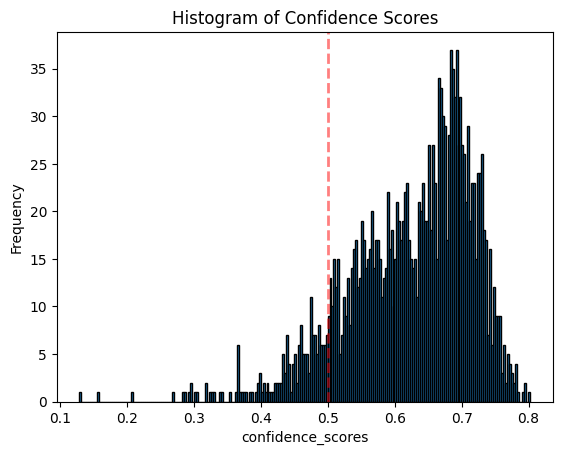

In [82]:
CONFIDENCE_THRESHOLD = 0.5
target_percentile = 90  # dont know if this should be fixed or not, maybe make it dependent on performance of test set

def calculate_confidence_score(s):
    normalized_s = s / MAX_STD  # Normalize by max_std (95th percentile)
    confidence_score = np.exp(-alpha * normalized_s)  # Apply exponential decay
    return confidence_score
    
std_dev_at_percentile = np.percentile(std_devs, target_percentile)  # Find the std_dev corresponding to the 25th percentile
alpha = -np.log(CONFIDENCE_THRESHOLD) / (std_dev_at_percentile / MAX_STD)  # Solve for alpha 
#alpha = 0.5 # fixed aloha
print("alpha:", alpha)

confidence_scores = [calculate_confidence_score(s) for s in std_devs]

max_confidence = max(confidence_scores)
min_confidence = min(confidence_scores)
print(f"Max Confidence Score: {max_confidence}")
print(f"Min Confidence Score: {min_confidence}")

plt.hist(confidence_scores, bins=len(confidence_scores)//8, edgecolor='black')  
plt.axvline(x=CONFIDENCE_THRESHOLD, color="red", alpha=0.5,linestyle='--', linewidth=2, label=f"Threshold = {CONFIDENCE_THRESHOLD}")
plt.xlabel('confidence_scores')
plt.ylabel('Frequency')
plt.title('Histogram of Confidence Scores')
plt.show()

In [ ]:
num_samples = 10

random.seed()
#sample = random.sample(results_hallucinate, num_samples)
sample = random.sample(results_not_hallucinate, num_samples)
for i, (real_sequence, predicted_sequence, std_predictions) in enumerate(sample):
    std_predictions = [0 if i is None else i for i in std_predictions]
    confidence = [calculate_confidence_score(i) if i else 0 for i in std_predictions]
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax[0].plot(predicted_sequence, label="Predicted Sequence", marker='x', linestyle='-')
    ax[0].plot(real_sequence, label="Real Sequence", marker='x', linestyle='-')
    ax[0].axvline(x=input_window - 1, color='#f77777', linestyle='-', label="Start Prediction")
    ax[0].set_ylabel("Sequence Values")
    ax[0].legend()
    ax[0].grid()

    ax[1].bar(range(len(confidence)), confidence, color='blue', alpha=0.7, label="Confidence")
    ax[1].axhline(y=CONFIDENCE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f"Confidence Threshold = {CONFIDENCE_THRESHOLD}")
    ax[1].set_ylim(0, 1)  # Confidence is between 0 and 1
    ax[1].set_ylabel("Confidence")
    ax[1].set_xlabel("Index")
    ax[1].legend()
    ax[1].grid()

    # Title and Show
    fig.suptitle(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()
    
    #ci_lower, ci_upper = np.array(predicted_sequence) - np.array(std_predictions), np.array(predicted_sequence) + np.array(std_predictions)
    #plt.fill_between(range(len(predicted_sequence)), ci_lower, ci_upper, color='gray', alpha=0.5, label="Standard Deviation")
    #plt.errorbar(range(len(predicted_sequence)) , predicted_sequence, yerr=confidence, fmt='-o', label='Data with Confidence', capsize=1)


### Load model

In [10]:
p = "models/transformer-model_emb32_dropout0.2_layers1_heads1_date09-12-2024.pth"
model = FloatSequenceTransformer() 
model.load_state_dict(torch.load(p))

C:\Users\daV\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [ ]:
model_save_path = f"models/{str(model)}.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# TODO

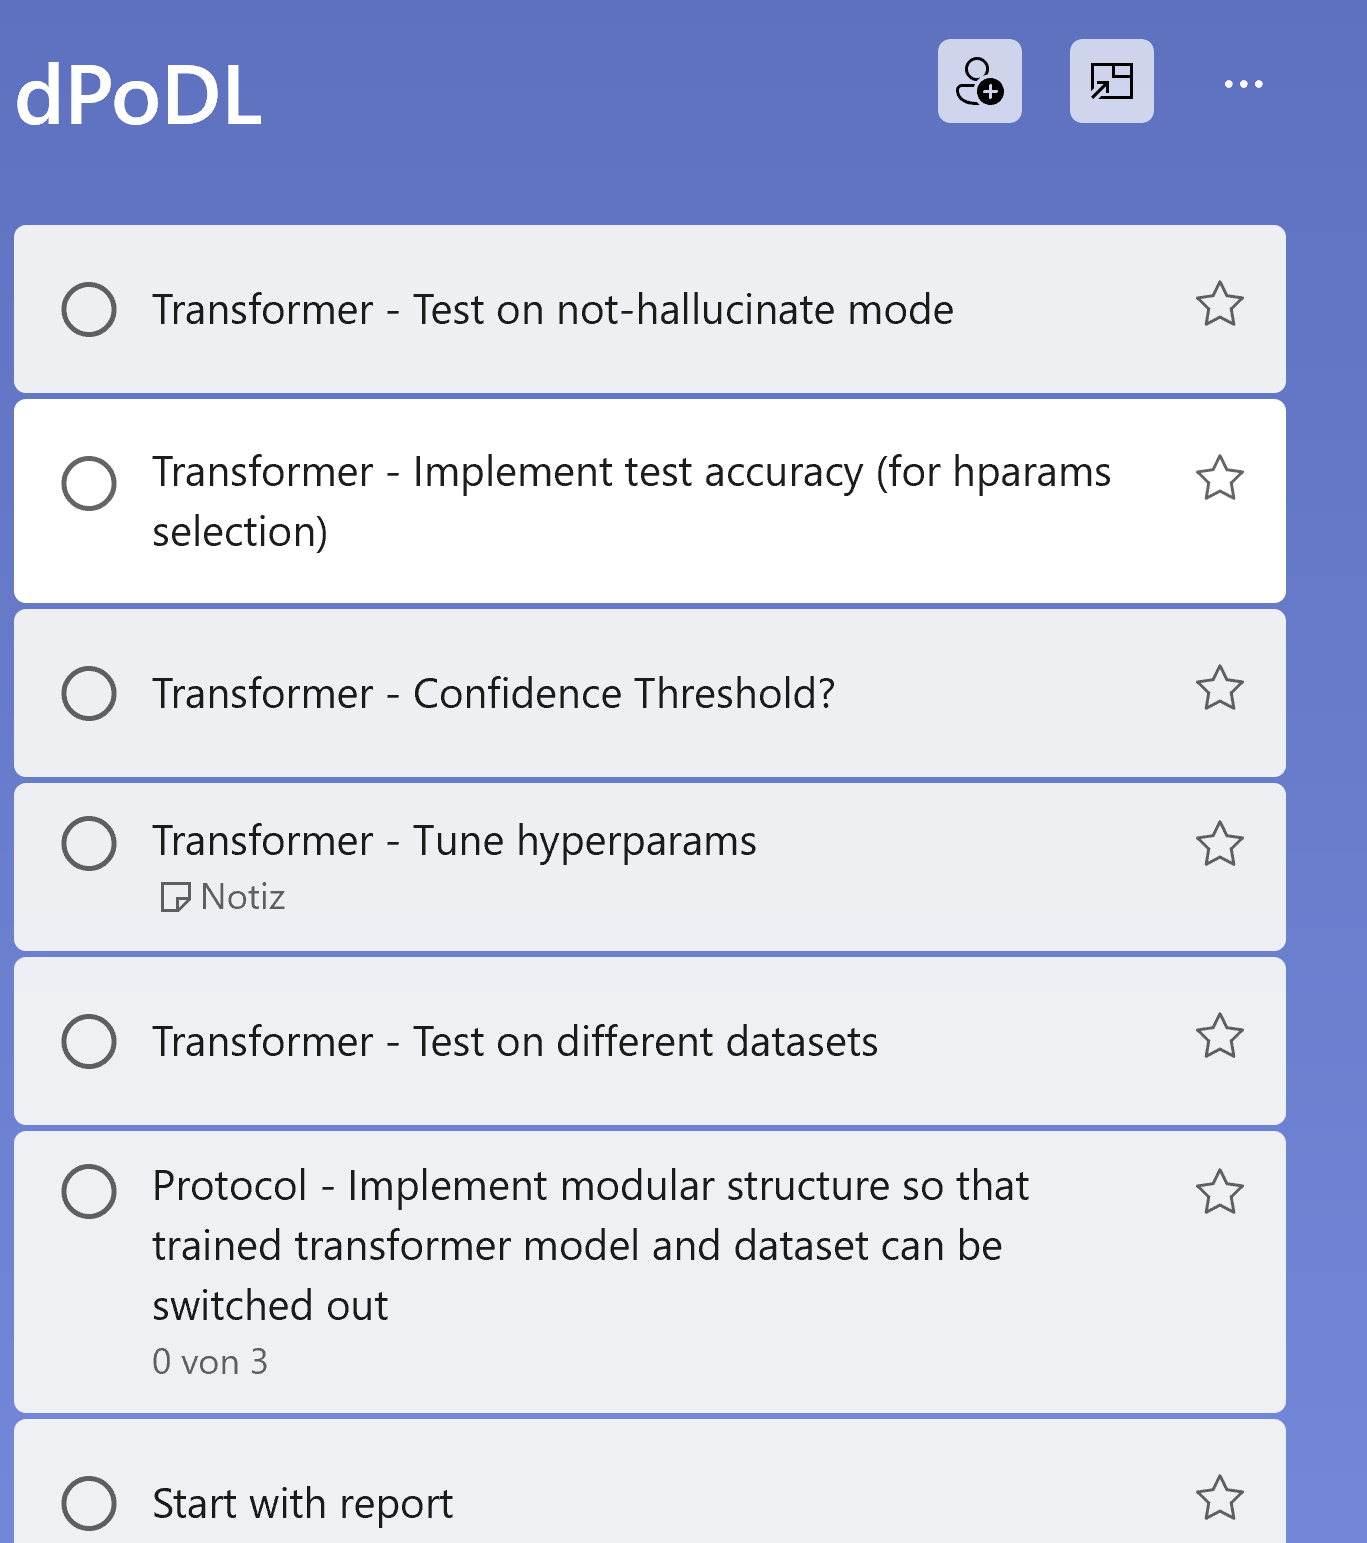
